In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import sqlite3
import mysql.connector as cnt


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


# import kagglehub

In [2]:
SDB = sqlite3.connect('Auto.db')
Cs = SDB.cursor()

sql="""select * from Autopliuslt;"""
df_with_dubs = pd.read_sql_query(sql, con=SDB)
df = df_with_dubs.drop_duplicates()
df.head(2)

,ID,Marke,Modelis,Kaina,Rida,Variklis,Kuras,PavaruDeze,VarantiejiRatai,BaterijosTalpakWh,...,Ilgis,Aukstis,TechApžiuraIki,COemisijagkm,EuroStandartas,TarsosMokestis,SDK,KlimatoValdymas,SedimosVietos,Ratlankiai
0,A26894037,Peugeot,208,19 500,49 452 km,"1199 cm³, 131 AG (96kW)",Benzinas,Automatinė,Priekiniai,None,...,None,None,None,122 g/km,Euro 6,0 €,None,Klimato kontrolė,5,R17
1,A26868959,Volkswagen,Golf,5 950,250 000 km,"1598 cm³, 105 AG (77kW)",Dyzelinas,Mechaninė,Visi varantys (4х4),None,...,None,None,2026-09,143 g/km,None,80.94 €,None,Klimato kontrolė,5,R18


In [3]:
def rida(x):
    if x != 'None':
        return int(x.replace(' ', '').replace('km', ''))
    else:
        return 'None'
        

def kaina(x):
    if x != 'None':
        return int(x.replace(' ', ''))

def amzius(x):
    if x != 'None':
        return int(2025 - int(x[:4]))

def galia(x):
    if 'kW' in x:
        return int(x.split('(')[-1][:-3])
    else:
        return 'None'
    
    
df['price'] = df['Kaina'].apply(kaina)
df['amzius'] = df['PirmaRegistracija'].apply(amzius)
df['rid'] = df['Rida'].apply(rida)
df['galia'] = df['Variklis'].apply(galia)

In [18]:
df.columns


Index(['ID', 'Marke', 'Modelis', 'Kaina', 'Rida', 'Variklis', 'Kuras',
       'PavaruDeze', 'VarantiejiRatai', 'BaterijosTalpakWh',
       'ElektraNuvažiuojamasAtstumas', 'Ikraunamas', 'Defektai', 'Spalva',
       'KebuloTipas', 'Vairas', 'VidutinesSanaudos', 'MiesteSanaudos',
       'UzmiestyjeSanaudos', 'PirmaRegistracija',
       'PirmosiosRegistracijosSalis', 'RegistracijosData', 'BendrojiMase',
       'NuosavaMase', 'DuruSkaicius', 'KebuloNr', 'Ilgis', 'Aukstis',
       'TechApžiuraIki', 'COemisijagkm', 'EuroStandartas', 'TarsosMokestis',
       'SDK', 'KlimatoValdymas', 'SedimosVietos', 'Ratlankiai', 'price',
       'amzius', 'rid', 'galia'],
      dtype='object')

In [4]:
# Gamintojas, Amžius, Kuro tipas, Rida, variklio galia kW, kaina Eurais

dff = df[['Marke', 'amzius','Kuras','rid' , 'galia', 'price' ]]
dff.dropna(inplace=True)
dff.head()



,Marke,amzius,Kuras,rid,galia,price
0,Peugeot,3.0,Benzinas,49452,96,19500
1,Volkswagen,14.0,Dyzelinas,250000,77,5950
2,BMW,10.0,Benzinas,199000,180,18000
3,Ford,15.0,Benzinas,213000,74,2950
4,Porsche,21.0,Benzinas,259000,331,5850


In [5]:
dff.replace('None', pd.NA, inplace=True)
dff.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
l = LabelEncoder().fit_transform(dff['Marke'])
dff['Marke'] = l
l = LabelEncoder().fit_transform(dff['Kuras'])
dff['Kuras'] = l
dff.head()

,Marke,amzius,Kuras,rid,galia,price
0,37,3.0,0,49452,96,19500
1,48,14.0,4,250000,77,5950
2,2,10.0,0,199000,180,18000
3,13,15.0,0,213000,74,2950
4,38,21.0,0,259000,331,5850


In [8]:
Y_target = dff['price']
X_features = dff.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X_features, Y_target, test_size=0.15, random_state=0)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train[['amzius','rid','galia']])
X_train_scaled = scaler.transform(X_train[['amzius','rid','galia']]); X_train_scaled

array([[ 0.33896983,  1.09559094,  1.24504632],
       [-0.63756374, -0.01186702,  0.24016752],
       [-0.63756374, -0.35080292,  0.8430948 ],
       ...,
       [-0.63756374,  0.08490115, -0.76471128],
       [-1.02817717, -1.64536752, -0.76471128],
       [-1.4187906 , -1.26698246,  0.38085055]])

In [10]:
PR_sc, R_sc, V_sc = zip(*X_train_scaled)
X_train['amzius'] = PR_sc
X_train['rid'] = R_sc
X_train['galia'] = V_sc ; X_train

,Marke,amzius,Kuras,rid,galia
1633,2,0.338970,4,1.095591,1.245046
3015,2,-0.637564,4,-0.011867,0.240168
3382,1,-0.637564,4,-0.350803,0.843095
2973,47,-1.418791,2,-1.339473,-0.764711
3169,2,-0.246950,4,0.771633,2.149437
...,...,...,...,...,...
870,13,0.729583,4,0.461222,-0.865199
948,1,1.315503,4,1.439656,0.863192
1841,31,-0.637564,0,0.084901,-0.764711
2830,47,-1.028177,2,-1.645368,-0.764711


In [11]:
np.std(X_train_scaled)

np.float64(1.0)

In [12]:
np.mean(X_train_scaled)

np.float64(3.328479284872264e-17)

In [13]:
# Apmokinome X_train
# Dabar su standart Scaler rescaliname X_test:
X_test_scaled = scaler.transform(X_test[['amzius','rid','galia']]); X_test_scaled

array([[ 0.92488997,  1.19409018, -0.06129612],
       [ 1.51081011,  0.52573393, -0.36275976],
       [-0.83287046, -1.33735443,  0.24016752],
       ...,
       [ 0.33896983,  0.9273756 , -1.02597977],
       [ 2.87795711,  1.99876054, -1.06617492],
       [-1.22348389, -1.62466988, -0.96568704]])

In [14]:
PR_sc, R_sc, V_sc = zip(*X_test_scaled)
X_test['amzius'] = PR_sc
X_test['rid'] = R_sc
X_test['galia'] = V_sc ; X_test

,Marke,amzius,Kuras,rid,galia
1232,1,0.924890,0,1.194090,-0.061296
732,5,1.510810,4,0.525734,-0.362760
3100,48,-0.832870,0,-1.337354,0.240168
658,6,0.729583,0,-1.090090,1.667095
141,2,1.510810,4,0.719270,-0.161784
...,...,...,...,...,...
541,1,1.510810,4,0.920860,-0.503443
1761,31,0.338970,0,0.215441,2.450901
1180,48,0.338970,4,0.927376,-1.025980
558,48,2.877957,4,1.998761,-1.066175


In [15]:
linearML = LinearRegression() # lininis modelis
linearML.fit(X_train, y_train) # apmokinimas

LinearRegression()

In [16]:
y_predicted = linearML.predict(X_test)

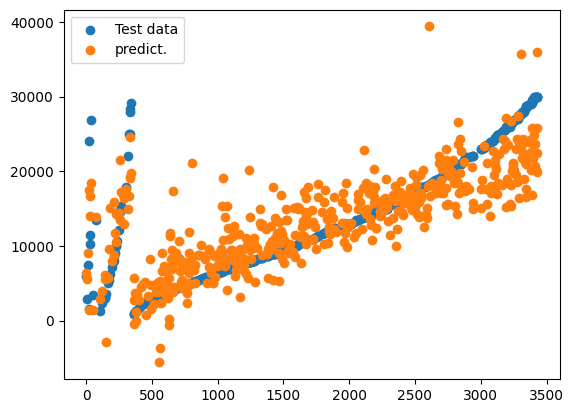

In [17]:
fig, ax = plt.subplots()
ax.scatter(X_test.index, y_test, label='Test data')
ax.scatter(X_test.index, y_predicted, label='predict.')
ax.legend(loc='best')
plt.show()

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [19]:
r2_score(y_test, y_predicted)

0.7130609099340562

In [20]:
mean_squared_error(y_test, y_predicted)

18511278.8822157

In [21]:
rmse = mean_squared_error(y_test, y_predicted)**(1/2)
rmse

4302.473577166477

In [ ]:
# MinMaxScaler()  - galimas variantas scalinti naudojant Min Max

In [ ]:
# El tinklo skirstomojo
# suvartojimas https://data.gov.lt/datasets/2677/#info
# , kas valandą, stambiųjų vart
# https://data.gov.lt/datasets/2678/#info
# .


# Sukurkite
# ir pateikite sekančių 24-rių valandų el. energijos suvartojimo
# spėjimą – 2 ML modelius bei spėjimus, pateiktus tiesiog
# apskaičiuojant vidutinį vartojimą. ML modeliai turi vertinti ir
# tikėtinas oro sąlygas. Palyginkite su NordPool duomenimis,
# paskaičiuokite įverčius (rmse, etc ...). Palyginkite dabar
# gautuosius rezultatus su anksčiau kurtų modelių rezultatais.

# Reikalavimai
# vidurkius kaip prognozę pateikiančiam kodui: kodas turi būti
# realizuotas kaip klasė, kurios pavadinimas averager(). Vidurkių
# apskaičiavimai, kuriuos naudosite prognozei, turi būti realizuoti
# fit() metode. Su predict() metodu, jūs turite galėti
# pasiimti modelio prognozę, nurodytam laikui arba laikų sąrašui.

In [22]:
sm = pd.read_json('../../../eismas/skirstomojo_tinklo_suvartojimas_mwh.json')
st = pd.read_json('../../../eismas/stambiuju_vartotoju_suvartojimas_mwh.json')


In [23]:
sm.head(2)

,id,value,ltu,utc
0,1101,683.070,2023-01-01 02:00:00,2023-01-01 00:00:00
1,1101,656.493,2023-01-01 03:00:00,2023-01-01 01:00:00


In [24]:
st.tail(2)

,id,value,ltu,utc
18476,1102,29.776,2025-02-08 22:00:00,2025-02-08 20:00:00
18477,1102,30.952,2025-02-08 23:00:00,2025-02-08 21:00:00


In [25]:
# bendra = pd.merge(sm, st, on='ltu', how='inner')
# bendra.head()

In [26]:
# bendra = bendra.rename(columns={'value_x': 'sm', 'value_y':'st'})
# bendra['ltu'] = pd.to_datetime(bendra['ltu'])
# bendra['hour'] = bendra['ltu'].dt.hour
# bendra['day'] = bendra['ltu'].dt.day
# bendra['month'] = bendra['ltu'].dt.day
# bendra['weekday'] = bendra['ltu'].dt.day_of_week
# bendra['year'] = bendra['ltu'].dt.year
# bendra.head(2)

In [27]:
# bendra['vartojimas'] = bendra['sm'] + bendra['st']
# bendra.head(2)

In [28]:
# bendra1 = bendra.iloc[22:]
# bendra1.tail(2)

In [29]:
# bendra1.tail(2)

In [30]:
sm['ltu'] = pd.to_datetime(sm['ltu'])
sm['hour'] = sm['ltu'].dt.hour
sm['day'] = sm['ltu'].dt.day
sm['month'] = sm['ltu'].dt.day
sm['weekday'] = sm['ltu'].dt.day_of_week
sm['year'] = sm['ltu'].dt.year
sm.head(2)

,id,value,ltu,utc,hour,day,month,weekday,year
0,1101,683.070,2023-01-01 02:00:00,2023-01-01 00:00:00,2,1,1,6,2023
1,1101,656.493,2023-01-01 03:00:00,2023-01-01 01:00:00,3,1,1,6,2023


In [35]:
sm1 = sm.iloc[22:]
sm1.head(2)

,id,value,ltu,utc,hour,day,month,weekday,year
22,1101,690.941,2023-01-02 00:00:00,2023-01-01 22:00:00,0,2,2,0,2023
23,1101,671.845,2023-01-02 01:00:00,2023-01-01 23:00:00,1,2,2,0,2023


In [31]:
st['ltu'] = pd.to_datetime(sm['ltu'])
st['hour'] = st['ltu'].dt.hour
st['day'] = st['ltu'].dt.day
st['month'] = st['ltu'].dt.day
st['weekday'] = st['ltu'].dt.day_of_week
st['year'] = st['ltu'].dt.year
st.head(2)

,id,value,ltu,utc,hour,day,month,weekday,year
0,1102,91.465,2023-01-01 02:00:00,2023-01-01 00:00:00,2,1,1,6,2023
1,1102,91.878,2023-01-01 03:00:00,2023-01-01 01:00:00,3,1,1,6,2023


In [37]:
st1 = st.iloc[22:]
st1.tail(2)

,id,value,ltu,utc,hour,day,month,weekday,year
18476,1102,29.776,2025-02-08 22:00:00,2025-02-08 20:00:00,22,8,8,5,2025
18477,1102,30.952,2025-02-08 23:00:00,2025-02-08 21:00:00,23,8,8,5,2025


In [32]:
orai1 = pd.read_csv('../../../eismas/VMS2023.csv')
orai2 = pd.read_csv('../../../eismas/VMS2024.csv')
orai3 = pd.read_csv('../../../eismas/VMS2025.csv')
orai3.tail(2)

,obs_time_utc,air_temperature,feels_like_temperature,wind_speed,wind_gust,wind_direction,cloud_cover,sea_level_pressure,relative_humidity,precipitation,condition_code
862,2025-02-08 22:00:00,-6.4,-10.6,2.5,5.7,129,0.0,1043.6,85,0.0,clear
863,2025-02-08 23:00:00,-6.5,-11.1,2.8,4.7,137,0.0,1043.6,85,0.0,clear


In [38]:
orai = pd.concat([orai1, orai2], axis=0, ignore_index=True)
orai = pd.concat([orai, orai3], axis=0, ignore_index=True)
orai.tail(2)

,obs_time_utc,air_temperature,feels_like_temperature,wind_speed,wind_gust,wind_direction,cloud_cover,sea_level_pressure,relative_humidity,precipitation,condition_code
18454,2025-02-08 22:00:00,-6.4,-10.6,2.5,5.7,129.0,0.0,1043.6,85.0,0.0,clear
18455,2025-02-08 23:00:00,-6.5,-11.1,2.8,4.7,137.0,0.0,1043.6,85.0,0.0,clear


In [39]:
orai = orai.rename(columns={'obs_time_utc': 'ltu'})
orai['ltu'] = pd.to_datetime(orai['ltu'])

In [40]:
data_sm = pd.merge(sm1, orai, on='ltu', how='inner')
data_sm.tail(2)

,id,value,ltu,utc,hour,day,month,weekday,year,air_temperature,feels_like_temperature,wind_speed,wind_gust,wind_direction,cloud_cover,sea_level_pressure,relative_humidity,precipitation,condition_code
18454,1101,1180.428,2025-02-08 22:00:00,2025-02-08 20:00:00,22,8,8,5,2025,-6.4,-10.6,2.5,5.7,129.0,0.0,1043.6,85.0,0.0,clear
18455,1101,1105.608,2025-02-08 23:00:00,2025-02-08 21:00:00,23,8,8,5,2025,-6.5,-11.1,2.8,4.7,137.0,0.0,1043.6,85.0,0.0,clear


In [41]:
l = LabelEncoder().fit_transform(data_sm['condition_code'])
data_sm['condition_code'] = l

In [43]:
data_sm.dropna(inplace=True)

In [45]:
data_st = pd.merge(st1, orai, on='ltu', how='inner')
l = LabelEncoder().fit_transform(data_st['condition_code'])
data_st['condition_code'] = l
data_st.dropna(inplace=True)

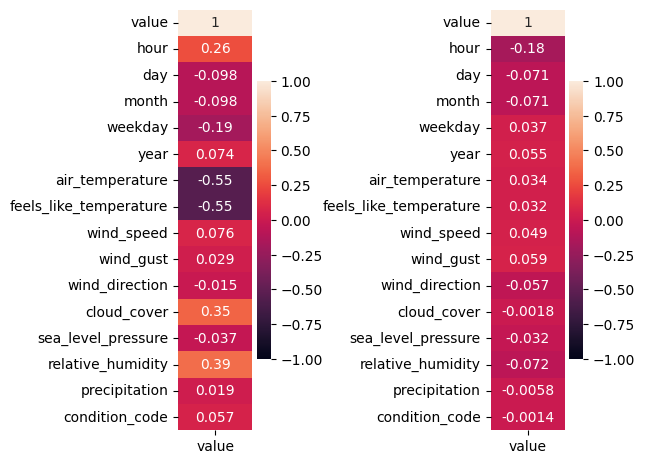

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.heatmap(data=data_sm.drop(columns=['id', 'utc', 'ltu']).corr()['value'].to_frame(), vmin=-1, vmax=1, annot=True, ax=ax1)
sns.heatmap(data=data_st.drop(columns=['id', 'utc', 'ltu']).corr()['value'].to_frame(), vmin=-1, vmax=1, annot=True, ax=ax2)
plt.tight_layout()
plt.show()

In [57]:
df_train_sm = data_sm.iloc[:-24]
# df_train_sm.tail(3)
df_test_sm = data_sm.iloc[-24:]
# df_test_sm.tail()
df_train_st = data_st.iloc[:-24]
df_test_st = data_st.iloc[-24:]


In [58]:
df_train_sm.columns

Index(['id', 'value', 'ltu', 'utc', 'hour', 'day', 'month', 'weekday', 'year',
       'air_temperature', 'feels_like_temperature', 'wind_speed', 'wind_gust',
       'wind_direction', 'cloud_cover', 'sea_level_pressure',
       'relative_humidity', 'precipitation', 'condition_code'],
      dtype='object')

In [65]:
# Linear Regression
X = df_train_sm.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_sm['value'].values      # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fit = LinearRegression().fit(X_train, y_train)
y_pred = fit.predict(X_test)
fit_score = fit.score(X_test, y_test) *100.0
print(f'fit score: {fit_score}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse}")

fit score: 47.73061928021346
Mean Squared Error: 231.58006334266648


In [63]:
# forest
X = df_train_sm.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_sm['value'].values      # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
forest_score = forest.score(X_test, y_test) *100.0
print(f'forest score: {forest_score}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse}")

forest score: 90.98472561769606
Mean Squared Error: 96.17605646847535


In [64]:
# tree
X = df_train_sm.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_sm['value'].values      # target  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=23)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
tree_reg_score = forest.score(X_test, y_test) *100.0
print(f'fit score: {tree_reg_score}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse}")

fit score: 90.98472561769606
Mean Squared Error: 132.9395414302804


In [66]:
#  stambiems
# Linear Regression
X = df_train_st.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_st['value'].values      # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fit = LinearRegression().fit(X_train, y_train)
y_pred = fit.predict(X_test)
fit_score = fit.score(X_test, y_test) *100.0
print(f'fit score: {fit_score}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse}")

fit score: 6.695169631882436
Mean Squared Error: 22.26780150617416


In [68]:
# stambiems
# forest
X = df_train_st.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_st['value'].values      # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
forest_score = forest.score(X_test, y_test) *100.0
print(f'forest score: {forest_score}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse}")

forest score: 79.14531362745542
Mean Squared Error: 10.52754506225227


In [69]:
# stambiems
# tree
X = df_train_st.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_st['value'].values      # target  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=23)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
tree_reg_score = forest.score(X_test, y_test) *100.0
print(f'fit score: {tree_reg_score}')

mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Squared Error: {mse}")

fit score: 79.14531362745542
Mean Squared Error: 15.628501304036668


In [72]:
# sm
X = df_train_sm.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_sm['value'].values      # target  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
# Make predictions
y_pred_forest_sm = rf.predict(df_test_sm.drop(columns=['id', 'value', 'ltu', 'utc']))

# treereg
regressor = DecisionTreeRegressor(random_state=23)
regressor.fit(X_train, y_train)
y_pred_treereg_sm = regressor.predict(df_test_sm.drop(columns=['id', 'value', 'ltu', 'utc']))


In [74]:
# st
X = df_train_st.drop(columns=['id', 'value', 'ltu', 'utc'])
y = df_train_st['value'].values      # target  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
# Make predictions
y_pred_forest_st = rf.predict(df_test_sm.drop(columns=['id', 'value', 'ltu', 'utc']))

# treereg
regressor = DecisionTreeRegressor(random_state=23)
regressor.fit(X_train, y_train)
y_pred_treereg_st = regressor.predict(df_test_sm.drop(columns=['id', 'value', 'ltu', 'utc']))

In [77]:
df_test_sm['rf'] = y_pred_forest_sm
df_test_sm['treereg'] = y_pred_treereg_sm
df_test_st['rf'] = y_pred_forest_st
df_test_st['treereg'] = y_pred_treereg_st


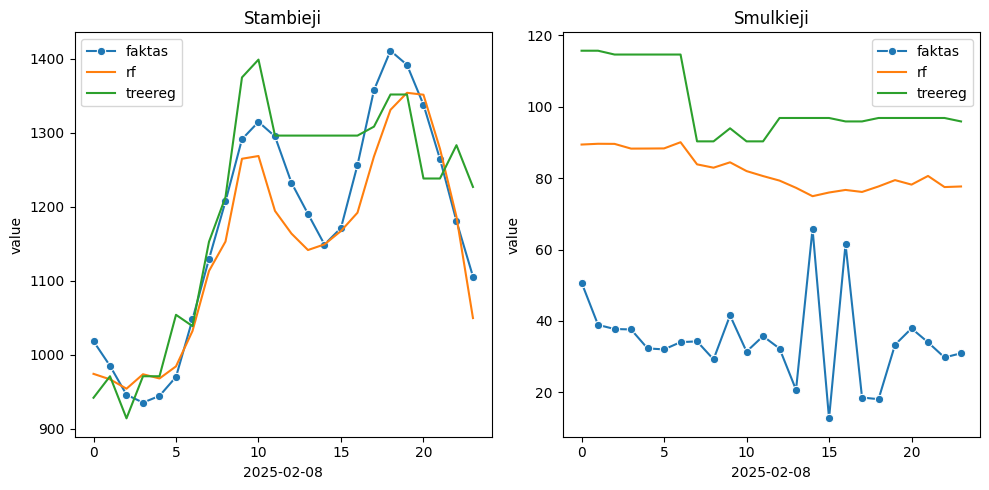

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
sns.lineplot(data=df_test_sm, x='hour', y='value', label='faktas', marker='o', ax=ax1)
sns.lineplot(data=df_test_sm, x='hour', y='rf', label='rf', ax=ax1)
sns.lineplot(data=df_test_sm, x='hour', y='treereg', label='treereg', ax=ax1)

sns.lineplot(data=df_test_st, x='hour', y='value', label='faktas', marker='o', ax=ax2)
sns.lineplot(data=df_test_st, x='hour', y='rf', label='rf', ax=ax2)
sns.lineplot(data=df_test_st, x='hour', y='treereg', label='treereg', ax=ax2)
ax1.set_title('Stambieji')
ax2.set_title('Smulkieji')
ax1.set_xlabel('2025-02-08')
ax2.set_xlabel('2025-02-08')
plt.legend()
plt.tight_layout()
plt.show()

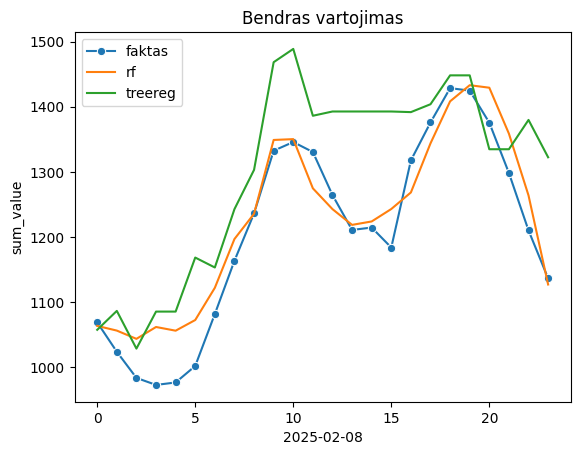

In [97]:
df_test_all = pd.DataFrame()
df_test_all['hour'] = df_test_sm['hour']
df_test_all['value_sm'] = df_test_sm['value']
df_test_all['value_St'] = df_test_st['value']
df_test_all['sum_value'] = df_test_all['value_sm'] + df_test_all['value_St'] 
df_test_all['rf_sm'] = y_pred_forest_sm
df_test_all['treereg_sm'] = y_pred_treereg_sm
df_test_all['rf_st'] = y_pred_forest_st
df_test_all['treereg_st'] = y_pred_treereg_st
df_test_all['sum_rf'] = df_test_all['rf_sm'] + df_test_all['rf_st']
df_test_all['sum_treereg'] = df_test_all['treereg_sm'] + df_test_all['treereg_st']

fig, ax1 = plt.subplots()
sns.lineplot(data=df_test_all, x='hour', y='sum_value', label='faktas', marker='o', ax=ax1)
sns.lineplot(data=df_test_all, x='hour', y='sum_rf', label='rf', ax=ax1)
sns.lineplot(data=df_test_all, x='hour', y='sum_treereg', label='treereg', ax=ax1)
ax1.set_xlabel('2025-02-08')
plt.title('Bendras vartojimas')
plt.legend()
plt.show()


In [ ]:
# vidurkius kaip prognozę pateikiančiam kodui: kodas turi būti
# realizuotas kaip klasė, kurios pavadinimas averager(). Vidurkių
# apskaičiavimai, kuriuos naudosite prognozei, turi būti realizuoti
# fit() metode. Su predict() metodu, jūs turite galėti
# pasiimti modelio prognozę, nurodytam laikui arba laikų sąrašui.

# paskaitos: 07-18, 07-24

# import pandas as pd
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# class Averager:
#     def __init__(self):
#         self.model = LinearRegression()  # or any other model
#         self.scaler = StandardScaler()   # to scale weather features
#         self.weather_columns = []        # to store column names used for prediction
#         self.fitted = False
    
#     def fit(self, df: pd.DataFrame, target_column: str, weather_columns: list):
#         """
#         Fit the model to the data. This method will learn the relationship
#         between weather conditions and energy consumption.
        
#         :param df: DataFrame containing the energy consumption and weather data.
#         :param target_column: The name of the target column (e.g., 'energy_consumption').
#         :param weather_columns: List of columns related to weather conditions.
#         """
#         self.weather_columns = weather_columns
#         X = df[weather_columns].copy()  # Use weather conditions as features
#         y = df[target_column]  # Energy consumption as the target
        
#         # Scale the weather data
#         X_scaled = self.scaler.fit_transform(X)
        
#         # Fit the model
#         self.model.fit(X_scaled, y)
#         self.fitted = True
    
#     def predict(self, times: list, df: pd.DataFrame, target_column: str) -> np.ndarray:
#         """
#         Predict energy consumption for a list of times based on weather conditions.

#         :param times: List of timestamps (datetime or str).
#         :param df: DataFrame containing the energy consumption and weather data.
#         :param target_column: The target column name.
#         :return: Array of predicted energy consumptions for each timestamp.
#         """
#         if not self.fitted:
#             raise ValueError("Model must be fitted before predicting.")
        
#         # Filter the DataFrame for the given times
#         df_times = df[df['timestamp'].isin(times)]
        
#         # Extract weather features at the specified times
#         X_new = df_times[self.weather_columns].copy()
        
#         # Scale the new weather data
#         X_scaled_new = self.scaler.transform(X_new)
        
#         # Predict using the fitted model
#         predictions = self.model.predict(X_scaled_new)
        
#         return predictions

# # Example usage:
# data = {
#     'timestamp': pd.to_datetime(['2025-02-10 08:00', '2025-02-10 09:00', '2025-02-10 10:00']),
#     'energy_consumption': [100, 150, 120],
#     'temperature': [22, 24, 23],
#     'humidity': [60, 55, 58]
# }

# df = pd.DataFrame(data)

# # Create an Averager instance
# averager = Averager()

# # Fit the model using energy consumption as the target and weather conditions as features
# averager.fit(df, target_column='energy_consumption', weather_columns=['temperature', 'humidity'])

# # Predict energy consumption for specific times
# predicted_energy = averager.predict(
#     times=[pd.to_datetime('2025-02-10 08:00'), pd.to_datetime('2025-02-10 09:00')],
#     df=df,
#     target_column='energy_consumption'
# )

# print(predicted_energy)
